In [26]:
# https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
from num2words import num2words
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import re
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split

import spacy
import en_core_web_sm


# Tfidf transformer 
from sklearn.feature_extraction.text import TfidfVectorizer

#https://www.nltk.org/howto/stem.html
from nltk.stem.porter import *


In [27]:
dataset = pd.read_csv('src/dataset_encoded.csv')
dataset['text_encoded'] = [eval(i) for i in dataset['text_encoded']]

In [28]:
reviews_pad = tf.keras.preprocessing.sequence.pad_sequences(dataset['text_encoded'], padding="post")

In [29]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(reviews_pad,dataset.target, test_size=0.3)

In [30]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

train_batch = train.shuffle(train.cardinality()).batch(64)
val_batch = val.shuffle(val.cardinality()).batch(64)

In [31]:
review = []
 # Some batch
for review, star in train_batch.take(1):
    # print(review, star)
    review = review

In [32]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") # instanciate the tokenizer
tokenizer.fit_on_texts(dataset.text)
dataset["text_encoded"] = tokenizer.texts_to_sequences(dataset.text)


In [39]:
dataset

,keyword,text,target,text_encoded
0,ablaz,ablaz bbcmtd wholesal market ablaz,1,"[213, 1, 1, 310, 213]"
1,ablaz,ablaz tri bring heavi metal rt,0,"[213, 220, 453, 697, 962, 90]"
2,ablaz,ablaz africanbaz break newsnigeria flag set...,1,"[213, 1, 270, 1, 527, 221, 213, 910]"
3,ablaz,ablaz cri set ablaz,0,"[213, 624, 221, 213]"
4,ablaz,ablaz plu look sky night ablaz,0,"[213, 1, 48, 724, 285, 213]"
...,...,...,...,...
7547,wreck,wreck jtruff23 cameronhack wreck,0,"[30, 1, 1, 30]"
7548,wreck,wreck day work ve pretti wreck hahaha shout...,0,"[30, 56, 98, 119, 588, 30, 1, 1, 58]"
7549,wreck,wreck fx forex trade cramer iger word wreck...,0,"[30, 1, 1, 1, 1, 1, 345, 30, 853, 364]"
7550,wreck,wreck enginesh great atmospher british lion...,0,"[30, 1, 233, 1, 756, 1, 1, 314, 383, 30]"


## Modeling

In [33]:
vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=(review.shape[1],),name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="linear")
])

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 8)             8008      
                                                                 
 global_average_pooling1d_1   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 16)                144       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,169
Trainable params: 8,169
Non-trainable params: 0
_________________________________________________________________


In [35]:
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [36]:
history = model.fit(train_batch, 
                    epochs=20, 
                    validation_data=val_batch)

Epoch 1/20
83/83 [==============================] - 1s 4ms/step - loss: 0.2932 - mean_absolute_error: 0.4681 - val_loss: 0.2387 - val_mean_absolute_error: 0.4858
Epoch 2/20
83/83 [==============================] - 0s 2ms/step - loss: 0.2308 - mean_absolute_error: 0.4747 - val_loss: 0.2164 - val_mean_absolute_error: 0.4575
Epoch 3/20
83/83 [==============================] - 0s 2ms/step - loss: 0.1980 - mean_absolute_error: 0.4322 - val_loss: 0.1770 - val_mean_absolute_error: 0.3955
Epoch 4/20
83/83 [==============================] - 0s 2ms/step - loss: 0.1587 - mean_absolute_error: 0.3575 - val_loss: 0.1549 - val_mean_absolute_error: 0.3309
Epoch 5/20
83/83 [==============================] - 0s 2ms/step - loss: 0.1411 - mean_absolute_error: 0.3112 - val_loss: 0.1510 - val_mean_absolute_error: 0.3178
Epoch 6/20
83/83 [==============================] - 0s 2ms/step - loss: 0.1349 - mean_absolute_error: 0.2938 - val_loss: 0.1496 - val_mean_absolute_error: 0.3008
Epoch 7/20
83/83 [==========

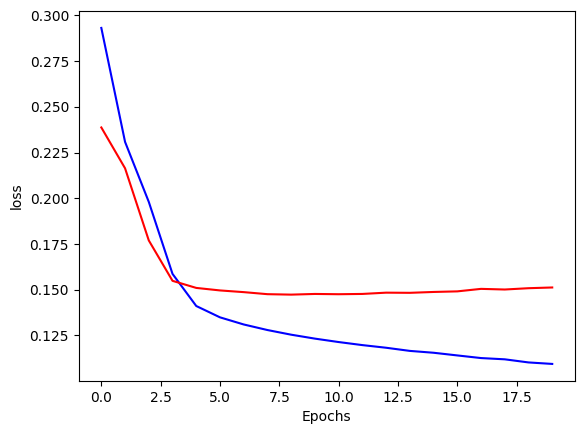

In [37]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

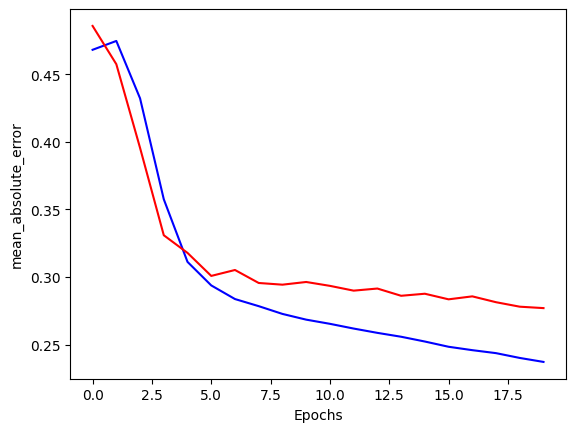

In [38]:
# Visualization of accuracy training 
plt.plot(history.history["mean_absolute_error"], color="b")
plt.plot(history.history["val_mean_absolute_error"], color="r")
plt.ylabel("mean_absolute_error")
plt.xlabel("Epochs")
plt.show()